<a href="https://colab.research.google.com/github/John1495/BBC-NYOK/blob/main/podcast_prediction_pipeline_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎧 Podcast Listening Time Prediction
This notebook performs data preprocessing, exploratory data analysis (EDA), feature engineering, and model training to predict podcast listening time.

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load data with optimized dtypes
df = dd.read_csv("/kaggle/Untitled Folder/train.csv", dtype={
    'Podcast_Name': 'category',
    'Episode_Title': 'category',
    'Genre': 'category',
    'Publication_Day': 'category',
    'Publication_Time': 'category',
    'Episode_Sentiment': 'category'
}).compute()

# Separate feature types
numerical_features = ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']
categorical_features = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Impute missing values
df[numerical_features] = SimpleImputer(strategy="median").fit_transform(df[numerical_features])
df[categorical_features] = SimpleImputer(strategy="most_frequent").fit_transform(df[categorical_features])

print("✅ Missing Values After Imputation:")
print(df.isnull().sum())

✅ Missing Values After Imputation:
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


## 🧠 Feature Engineering

In [3]:
# Aggregations
podcast_features = df.groupby("Podcast_Name").agg(
    avg_podcast_listening_time=('Listening_Time_minutes', 'mean'),
    median_podcast_listening_time=('Listening_Time_minutes', 'median'),
    total_podcast_listens=('Listening_Time_minutes', 'count'),
    std_podcast_listening_time=('Listening_Time_minutes', 'std'),
    avg_episode_length=('Episode_Length_minutes', 'mean'),
    avg_host_popularity=('Host_Popularity_percentage', 'mean'),
    avg_guest_popularity=('Guest_Popularity_percentage', 'mean'),
    avg_num_ads=('Number_of_Ads', 'mean')
).reset_index()

genre_features = df.groupby("Genre").agg(
    avg_genre_listening_time=('Listening_Time_minutes', 'mean'),
    avg_genre_episode_length=('Episode_Length_minutes', 'mean'),
    total_genre_listens=('Listening_Time_minutes', 'count')
).reset_index()

sentiment_features = df.groupby("Episode_Sentiment").agg(
    avg_sentiment_listening_time=('Listening_Time_minutes', 'mean'),
    total_sentiment_listens=('Listening_Time_minutes', 'count')
).reset_index()

day_features = df.groupby("Publication_Day").agg(
    avg_day_listening_time=('Listening_Time_minutes', 'mean'),
    total_day_listens=('Listening_Time_minutes', 'count')
).reset_index()

# Merge engineered features
df = df.merge(podcast_features, on="Podcast_Name", how="left")
df = df.merge(genre_features, on="Genre", how="left")
df = df.merge(sentiment_features, on="Episode_Sentiment", how="left")
df = df.merge(day_features, on="Publication_Day", how="left")
df.fillna(0, inplace=True)  # Handle any remaining NaNs


## 🤖 Model Training and Evaluation

In [4]:
# Prepare data
df_model = df.copy()
df_model.drop(['id', 'Episode_Title'], axis=1, inplace=True)

# Encode categorical variables
for col in ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

X = df_model.drop('Listening_Time_minutes', axis=1)
y = df_model['Listening_Time_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.2f}")

results_df = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"]).sort_values(by="RMSE")
results_df

Linear Regression RMSE: 13.34
Random Forest RMSE: 12.82
Gradient Boosting RMSE: 13.12
XGBoost RMSE: 13.03


,Model,RMSE
1,Random Forest,12.816291
3,XGBoost,13.027623
2,Gradient Boosting,13.123545
0,Linear Regression,13.342556


## 📉 Residual Analysis

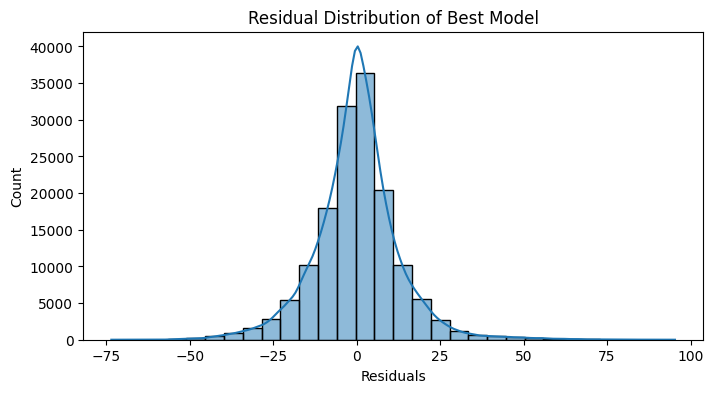

In [5]:
# Check residuals of the best model
best_model = models[results_df.iloc[0]['Model']]
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution of Best Model")
plt.xlabel("Residuals")
plt.show()
